In [1]:
# sets the correct path, don't know how to toggle this once it is set
%cd ../
%pwd

/home/thomas/Development/resonator-hackathon/ssm/equinox


/home/thomas/Development/resonator-hackathon/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/home/thomas/Development/resonator-hackathon/ssm/equinox'

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
import jax 
import jax.numpy as jnp
import equinox as eqx
import optax
from tqdm import tqdm
from typing import Callable
import wandb
import math
import numpy as np

from resonator_s5.classifier import Classifier
from functools import partial

def bitreversal_po2(n):
    """
    From S4 codebase.

    :param n:
    :return:
    """
    m = int(math.log(n)/math.log(2))
    perm = np.arange(n).reshape(n,1)
    for i in range(m):
        n1 = perm.shape[0]//2
        perm = np.hstack((perm[:n1],perm[n1:]))
    return perm.squeeze(0)

def bitreversal_permutation(n):
    """
    From S4 codebase.

    :param n:
    :return:
    """
    m = int(math.ceil(math.log(n)/math.log(2)))
    N = 1 << m
    perm = bitreversal_po2(N)
    return np.extract(perm < n, perm)

BATCH_SIZE = 50
EPOCHS = 300
PERMUTE = True

transform = [
    transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x.view(1, 28*28).t()),
]
if PERMUTE:
    permutation = bitreversal_permutation(28*28)
    transform.append(torchvision.transforms.Lambda(lambda x: x[permutation]))

transform = transforms.Compose(transform)

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='../../data', train=True, download=True, transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.9, 0.1])
test_dataset = datasets.MNIST(root='../../data', train=False, download=True, transform=transform)


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [3]:
rng_key = jax.random.PRNGKey(42)
rng_key, model_key = jax.random.split(rng_key, num=2)

model = Classifier(
    rng_key=model_key,
    input_dim=1,
    output_dim=10,
    num_neurons=[128, 128],
    num_blocks=[8, 8],
    dt_min=0.001,
    dt_max=0.1,
    activation="cartesian_spike",
    discretization="zoh",
    bidirectional=False,
    keep_imag=True,
    v_pos="before_spike",
    apply_skip=True,
    dropout=0.15,
    dense_dropout = False,
)
model

2024-06-09 22:48:58.330313: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Classifier(
  dense_layers=[
    RFDense(C=f32[128,1,2], keep_imag=True),
    RFDense(C=f32[128,128,2], keep_imag=True)
  ],
  neuron_layers=[
    RF(
      Lambda=f32[128,2],
      V=c64[128,128],
      log_step=f32[128,1],
      keep_imag=True,
      discretization='zoh',
      activation='cartesian_spike',
      bidirectional=False,
      step_rescale=1.0
    ),
    RF(
      Lambda=f32[128,2],
      V=c64[128,128],
      log_step=f32[128,1],
      keep_imag=True,
      discretization='zoh',
      activation='cartesian_spike',
      bidirectional=False,
      step_rescale=1.0
    )
  ],
  drop=Dropout(p=0.15, inference=False),
  output_dense=RFDense(C=f32[10,128,2], keep_imag=False),
  apply_skip=True,
  dense_dropout=False
)

In [4]:
model.neuron_layers[0].Lambda[...,1]

Array([-80.966194 , -25.629253 , -13.834365 ,  -8.362114 ,  -5.090026 ,
        -2.8996723,  -1.3719904,  -0.3520182,   0.3520182,   1.3719904,
         2.8996742,   5.0900235,   8.362113 ,  13.834335 ,  25.629234 ,
        80.96615  , -80.966194 , -25.629253 , -13.834365 ,  -8.362114 ,
        -5.090026 ,  -2.8996723,  -1.3719904,  -0.3520182,   0.3520182,
         1.3719904,   2.8996742,   5.0900235,   8.362113 ,  13.834335 ,
        25.629234 ,  80.96615  , -80.966194 , -25.629253 , -13.834365 ,
        -8.362114 ,  -5.090026 ,  -2.8996723,  -1.3719904,  -0.3520182,
         0.3520182,   1.3719904,   2.8996742,   5.0900235,   8.362113 ,
        13.834335 ,  25.629234 ,  80.96615  , -80.966194 , -25.629253 ,
       -13.834365 ,  -8.362114 ,  -5.090026 ,  -2.8996723,  -1.3719904,
        -0.3520182,   0.3520182,   1.3719904,   2.8996742,   5.0900235,
         8.362113 ,  13.834335 ,  25.629234 ,  80.96615  , -80.966194 ,
       -25.629253 , -13.834365 ,  -8.362114 ,  -5.090026 ,  -2.8

In [5]:
jnp.exp(model.forward(jnp.ones([784, 1]), rng_key=rng_key))

Array([0.07225227, 0.11110634, 0.09259634, 0.09673653, 0.10634853,
       0.09437726, 0.12435078, 0.09126202, 0.11232641, 0.0986435 ],      dtype=float32)

In [6]:
from resonator_s5.optax_helper import init_optimizer

decay_steps = EPOCHS * len(train_dataloader)
if PERMUTE:
    standard_lr = 0.004
    ssm_lr = 0.001
else:
    standard_lr = 0.008
    ssm_lr = 0.002

optim, opt_state = init_optimizer(model, standard_lr=standard_lr, ssm_lr=ssm_lr, weight_decay=0.0001, decay_steps=decay_steps)

In [7]:
opt_state.inner_states['standard'].inner_state.hyperparams['learning_rate']

Array(0.004, dtype=float32)

In [8]:
def loss_fn(model: Classifier, train_key, x: jax.Array, y: jax.Array):
    call = partial(model.forward, rng_key=train_key)
    batched_model = jax.vmap(call, in_axes=(0), out_axes=(0)) # add batch dim to x only
    logits = batched_model(x)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y)
    loss = loss.mean()
    return loss, (logits)


# x , y = next(iter(test_dataloader))
# x = jnp.asarray(x.numpy())
# y = jnp.asarray(y.numpy())

# value, grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model, rng_key, x, y)

# lrs = []
# for _ in tqdm(range(1080)):
#     updates, opt_state = optim.update(grads, opt_state, model)
#     lr = opt_state.inner_states['standard'].inner_state.hyperparams['learning_rate']
#     lrs.append(lr)

# model = eqx.apply_updates(model, updates)

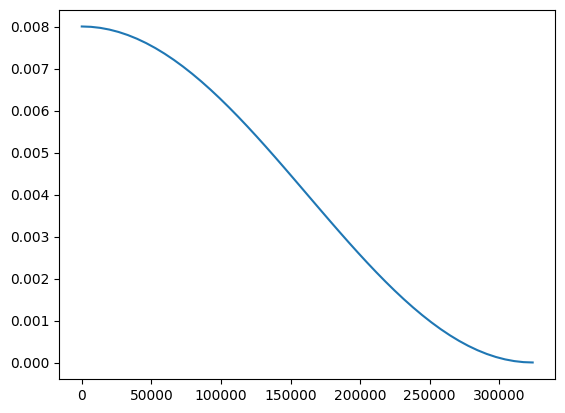

In [9]:
import matplotlib.pyplot as plt
x = jnp.linspace(0, 1080*300)
y = 0.008 * (1-1e-6)/2 * (1 + jnp.cos(jnp.pi * x/decay_steps)) + 1e-6
plt.plot(x, y)

In [10]:
opt_state.inner_states['standard'].inner_state.hyperparams['learning_rate']

Array(0.004, dtype=float32)

In [11]:
@eqx.filter_jit
def train_step(model: Classifier, train_key, opt_state, x: jax.Array, y: jax.Array):
    (loss_value, (logits)), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model, train_key, x, y)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    metrics = {
        'loss': loss_value,
        'accuracy': jnp.mean(jnp.argmax(logits, -1) == y),
    }
    return model, opt_state, metrics


@eqx.filter_jit
def test_step(model: Classifier, rng_key, x, y):
    loss_value, (logits) = loss_fn(model, rng_key, x, y)
    metrics = {
        'loss': loss_value,
        'accuracy': jnp.mean(jnp.argmax(logits, -1) == y),
    }
    return metrics

@eqx.filter_jit
def get_average_spikes(model: Classifier, x: jax.Array, layer: int) -> tuple[jax.Array, jax.Array]:
    spikes_fn = partial(model.gen_spikes, layer=layer)
    spikes = jax.vmap(spikes_fn)(x)
    return (jnp.sum(spikes) / BATCH_SIZE).astype(jnp.int32), jnp.mean(spikes)



def train_epoch(model: Classifier, rng_key, opt_state, track_layer: int):
    train_metrics = {
        'loss': [],
        'accuracy': [],
    }
    val_metrics = {
        'loss': [],
        'accuracy': [],
        'num_spikes': [],
        'avg_spikes': [],
    }
    test_metrics = {
        'loss': [],
        'accuracy': [],
        'num_spikes': [],
        'avg_spikes': [],
    }
    print("training")
    for x, y in tqdm(train_dataloader):
        x = jnp.asarray(x.numpy())
        y = jnp.asarray(y.numpy())

        rng_key, train_key = jax.random.split(rng_key, num=2)
        model, opt_state, metric = train_step(model, train_key, opt_state, x, y)
        train_metrics['loss'].append(metric['loss'])
        train_metrics['accuracy'].append(metric['accuracy'])
    
    print("validating")
    inference_model = eqx.nn.inference_mode(model)
    for x, y in tqdm(val_dataloader): 
            x = jnp.asarray(x.numpy())
            y = jnp.asarray(y.numpy())
            metric = test_step(inference_model, rng_key, x, y)
            val_metrics['loss'].append(metric['loss'])
            val_metrics['accuracy'].append(metric['accuracy'])

    num_spikes, avg_spikes = get_average_spikes(model, x, layer=track_layer)
    val_metrics['num_spikes'] = num_spikes
    val_metrics['avg_spikes'] = avg_spikes

    print("testing")
    for x, y in tqdm(test_dataloader): 
        x = jnp.asarray(x.numpy())
        y = jnp.asarray(y.numpy())
        metric = test_step(inference_model, rng_key, x, y)
        test_metrics['loss'].append(metric['loss'])
        test_metrics['accuracy'].append(metric['accuracy'])
    
    num_spikes, avg_spikes = get_average_spikes(model, x, layer=track_layer)
    test_metrics['num_spikes'] = num_spikes
    test_metrics['avg_spikes'] = avg_spikes

    train_metrics['loss'] = jnp.array(train_metrics['loss']).mean()
    train_metrics['accuracy'] = jnp.array(train_metrics['accuracy']).mean()
    val_metrics['loss'] = jnp.array(val_metrics['loss']).mean()
    val_metrics['accuracy'] = jnp.array(val_metrics['accuracy']).mean()
    test_metrics['loss'] = jnp.array(test_metrics['loss']).mean()
    test_metrics['accuracy'] = jnp.array(test_metrics['accuracy']).mean()

    print(f"Train Loss: {train_metrics['loss']}")
    print(f"Train Acc: {train_metrics['accuracy']}")
    print(f"Val Loss: {val_metrics['loss']}")
    print(f"Val Acc: {val_metrics['accuracy']}")
    print(f"Test Loss: {test_metrics['loss']}")
    print(f"Test Acc: {test_metrics['accuracy']}\n")

    return model, opt_state, train_metrics, val_metrics, test_metrics

In [12]:
class BestAccTracker:
    def __init__(self) -> None:
        self.counter = 0
        self.best_acc = 0
    
    def update(self, x: jax.Array | float) -> None:
        if x > self.best_acc:
            self.best_acc = x
            self.reset_counter()
        else:
            self.counter += 1
    
    def reset_counter(self) -> None:
        self.counter = 0



some_nan = lambda x: np.sum(np.isnan(x)) > 0

In [13]:
from IPython.display import clear_output

if PERMUTE:
    wandb.init(project="S5_PSMNIST")
else:
    wandb.init(project="S5_SMNIST")

rng_key = jax.random.PRNGKey(42)
tracker = BestAccTracker()
track_layer = 1
for epoch in range(EPOCHS):
    if (epoch % 5) == 0: 
        clear_output(wait=True)
    print(f"Epoch: {epoch+1}/{EPOCHS}")
    model, opt_state, train_metrics, val_metrics, test_metrics = train_epoch(model, rng_key, opt_state, track_layer=track_layer)
    tracker.update(val_metrics["accuracy"])

    wandb.log({
        "Train Loss": train_metrics['loss'], 
        "Train Accuracy": train_metrics['accuracy'], 
        "Val Loss": val_metrics['loss'], 
        "Val Accuracy": val_metrics['accuracy'],
        "Test Loss": test_metrics['loss'], 
        "Test Accuracy": test_metrics['accuracy'],
        "Max Lambda real": -jnp.exp(model.neuron_layers[track_layer].Lambda[...,0].min()),
        "Min Lambda real": -jnp.exp(model.neuron_layers[track_layer].Lambda[...,0].max()),
        "Max Lambda imag": model.neuron_layers[track_layer].Lambda[...,1].max(),
        "Min Lambda imag": model.neuron_layers[track_layer].Lambda[...,1].min(),
        "Max C real": model.dense_layers[track_layer].C[...,0].max(),
        "Min C real": model.dense_layers[track_layer].C[...,0].min(),
        "Max C imag": model.dense_layers[track_layer].C[...,1].max(),
        "Min C imag": model.dense_layers[track_layer].C[...,1].min(),
        "Max Delta": jnp.exp(model.neuron_layers[track_layer].log_step.max()),
        "Min Delta": jnp.exp(model.neuron_layers[track_layer].log_step.min()),
        "Val Num Spikes": val_metrics['num_spikes'], 
        "Val Avg Spikes": val_metrics['avg_spikes'],
        "Test Num Spikes": test_metrics['num_spikes'], 
        "Test Avg Spikes": test_metrics['avg_spikes'],
        "Learning Rate Standard": opt_state.inner_states['standard'].inner_state.hyperparams['learning_rate'],
        "Learning Rate SSM": opt_state.inner_states['ssm'].inner_state.hyperparams['learning_rate'],
        "Counter": tracker.counter,
        }
    )

    if tracker.counter >= 20:
        lr_standard = opt_state.inner_states['standard'].inner_state.hyperparams['learning_rate']
        lr_ssm = opt_state.inner_states['ssm'].inner_state.hyperparams['learning_rate']
        lr_standard = max(0.2 * lr_standard, 1e-6) 
        lr_ssm = max(0.2 * lr_ssm, 1e-6)
        opt_state.inner_states['standard'].inner_state.hyperparams['learning_rate'] = lr_standard
        opt_state.inner_states['ssm'].inner_state.hyperparams['learning_rate'] = lr_ssm
        tracker.reset_counter()

    if some_nan(model.neuron_layers[track_layer].Lambda):
        print("Lambda nan")
        break
    if some_nan(model.dense_layers[track_layer].C):
        print("C nan")
        break
    if some_nan(model.neuron_layers[track_layer].log_step):
        print("Delta nan")
        break

wandb.finish()

Epoch: 296/300
training


100%|██████████| 1080/1080 [00:17<00:00, 62.55it/s]


validating


100%|██████████| 120/120 [00:00<00:00, 198.33it/s]


testing


100%|██████████| 200/200 [00:00<00:00, 207.16it/s]


Train Loss: 0.05248219519853592
Train Acc: 0.98370361328125
Val Loss: 0.2038150131702423
Val Acc: 0.9423333406448364
Test Loss: 0.18421746790409088
Test Acc: 0.9470999836921692

Epoch: 297/300
training


100%|██████████| 1080/1080 [00:17<00:00, 62.71it/s]


validating


100%|██████████| 120/120 [00:00<00:00, 192.32it/s]


testing


100%|██████████| 200/200 [00:00<00:00, 202.02it/s]


Train Loss: 0.052081502974033356
Train Acc: 0.9843332767486572
Val Loss: 0.20397083461284637
Val Acc: 0.9426666498184204
Test Loss: 0.1840483397245407
Test Acc: 0.947700023651123

Epoch: 298/300
training


100%|██████████| 1080/1080 [00:17<00:00, 63.03it/s]


validating


100%|██████████| 120/120 [00:00<00:00, 182.68it/s]


testing


100%|██████████| 200/200 [00:01<00:00, 193.46it/s]


Train Loss: 0.05218548700213432
Train Acc: 0.9845925569534302
Val Loss: 0.20381805300712585
Val Acc: 0.9426666498184204
Test Loss: 0.18420535326004028
Test Acc: 0.9474999904632568

Epoch: 299/300
training


100%|██████████| 1080/1080 [00:17<00:00, 62.99it/s]


validating


100%|██████████| 120/120 [00:00<00:00, 196.54it/s]


testing


100%|██████████| 200/200 [00:00<00:00, 204.19it/s]


Train Loss: 0.052613984793424606
Train Acc: 0.9845185279846191
Val Loss: 0.20373988151550293
Val Acc: 0.9426666498184204
Test Loss: 0.18409541249275208
Test Acc: 0.9476999640464783

Epoch: 300/300
training


100%|██████████| 1080/1080 [00:17<00:00, 62.88it/s]


validating


100%|██████████| 120/120 [00:00<00:00, 197.34it/s]


testing


100%|██████████| 200/200 [00:00<00:00, 207.07it/s]


Train Loss: 0.052706461399793625
Train Acc: 0.9839258193969727
Val Loss: 0.2037438452243805
Val Acc: 0.9426666498184204
Test Loss: 0.1841287612915039
Test Acc: 0.9476999640464783



Counter,▁▁▁▂▁▅▃▃▁▅▂▅▂▃▆▂▅█▃▆█▃▆▂▅█▁▄▇▃▄▇▃▂▅█▃▆▂▅
Learning Rate SSM,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Learning Rate Standard,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
Max C imag,▁▁▃▃▃▃▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇█████████████████
Max C real,▁▃▄▃▃▃▃▃▃▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇▇███████████████
Max Delta,▁▁▂▂▃▅▇▇▇▇▇▇▇▇███▇██████████████████████
Max Lambda imag,█▇▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Max Lambda real,▁▂▂▃▄▅▆▇▇▇▇█████████████████████████████
Min C imag,█▇▆▅▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Min C real,█▇▇▆▆▆▆▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Min Delta,▃▁▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████████████████


In [14]:
opt_state.inner_states['standard'].inner_state#.hyperparams['learning_rate']

InjectStatefulHyperparamsState(count=Array(324000, dtype=int32), hyperparams={'b1': Array(0.9, dtype=float32), 'b2': Array(0.999, dtype=float32), 'eps': Array(1.e-08, dtype=float32), 'eps_root': Array(0., dtype=float32), 'learning_rate': Array(4.0000003e-09, dtype=float32), 'weight_decay': Array(1.e-04, dtype=float32)}, hyperparams_states={'learning_rate': WrappedScheduleState(count=Array(324000, dtype=int32))}, inner_state=(ScaleByAdamState(count=Array(324000, dtype=int32), mu=Classifier(
  dense_layers=[
    RFDense(C=f32[128,1,2], keep_imag=None),
    RFDense(C=f32[128,128,2], keep_imag=None)
  ],
  neuron_layers=[
    RF(
      Lambda=MaskedNode(),
      V=c64[128,128],
      log_step=MaskedNode(),
      keep_imag=None,
      discretization=None,
      activation=None,
      bidirectional=None,
      step_rescale=None
    ),
    RF(
      Lambda=MaskedNode(),
      V=c64[128,128],
      log_step=MaskedNode(),
      keep_imag=None,
      discretization=None,
      activation=None,
 

In [15]:
wandb.finish()

In [16]:
model.dense_layers[0].C

Array([[[ 27.278822  , -24.290009  ]],

       [[  9.04946   ,  -0.60241866]],

       [[-12.776334  ,  11.450195  ]],

       [[ -1.4368594 ,   4.580741  ]],

       [[  2.6500046 ,  -2.7598403 ]],

       [[ -7.8545566 ,  -5.8173122 ]],

       [[ -7.3235254 ,  -2.611602  ]],

       [[  3.063571  ,  -2.6140704 ]],

       [[  4.804577  ,  -1.9316543 ]],

       [[  4.0230126 ,  -8.148915  ]],

       [[  5.3830557 ,   9.766233  ]],

       [[ -2.8931901 ,  -9.930417  ]],

       [[ -0.23690687,   8.077544  ]],

       [[ -5.996838  , -14.634781  ]],

       [[  8.636294  ,   1.1379813 ]],

       [[  5.762111  ,  -1.2551748 ]],

       [[-18.061985  ,  23.016537  ]],

       [[ 16.760975  ,  -9.078444  ]],

       [[-26.85386   ,   4.6326513 ]],

       [[ -3.7941308 ,   7.191519  ]],

       [[ -6.526105  ,   6.013699  ]],

       [[ -4.328576  ,  14.019147  ]],

       [[  4.1364856 ,   0.95749795]],

       [[  5.990868  ,  -5.379472  ]],

       [[ -1.5768486 ,  -4.3256674 ]],



In [17]:
model.neuron_layers[0].log_step

Array([[-3.7357092],
       [-4.874747 ],
       [-6.4224486],
       [-4.884924 ],
       [-2.705266 ],
       [-2.9434452],
       [-3.7893107],
       [-4.139554 ],
       [-3.243043 ],
       [-3.5081875],
       [-3.1385634],
       [-6.176812 ],
       [-6.3344064],
       [-2.4567695],
       [-5.0986753],
       [-5.975911 ],
       [-4.9377522],
       [-3.685719 ],
       [-3.2294002],
       [-6.729537 ],
       [-5.57362  ],
       [-2.7049546],
       [-5.4666924],
       [-5.053391 ],
       [-1.9798536],
       [-5.2588134],
       [-5.5401673],
       [-5.529785 ],
       [-4.81016  ],
       [-3.7567284],
       [-4.4934936],
       [-5.2399135],
       [-4.526295 ],
       [-6.2889175],
       [-3.4541533],
       [-2.6547797],
       [-5.602897 ],
       [-2.6891038],
       [-4.4130173],
       [-4.475315 ],
       [-6.2932897],
       [-3.154357 ],
       [-4.628452 ],
       [-5.5261617],
       [-2.8068569],
       [-2.375907 ],
       [-5.913476 ],
       [-3.81

In [18]:
model.neuron_layers[0].Lambda

Array([[-9.0397161e-01, -8.0832527e+01],
       [-3.2216146e+00, -2.5509569e+01],
       [-4.5083728e+00, -1.2406454e+01],
       [-2.4737077e+00, -8.0883961e+00],
       [-1.8148924e+00, -4.8454223e+00],
       [-5.9536886e-01, -2.3399389e+00],
       [-1.5766857e+00, -3.5577831e-01],
       [-8.5434055e-01, -1.2893005e-01],
       [-1.3528788e+00,  1.3121776e-01],
       [-2.7094519e+00,  9.8654115e-01],
       [-1.0293022e+00,  2.8548605e+00],
       [-2.2040851e+00,  4.4087629e+00],
       [-2.6379955e+00,  8.0918465e+00],
       [-1.3943064e+00,  1.3864461e+01],
       [-9.4323391e-01,  2.5502949e+01],
       [-4.7012997e-01,  8.0843445e+01],
       [-1.8794339e+00, -8.0908989e+01],
       [-1.7383585e+00, -2.5623234e+01],
       [-5.6506234e-01, -1.3385138e+01],
       [-2.6749904e+00, -7.4241285e+00],
       [-1.6783075e+00, -3.8154252e+00],
       [-1.9912550e+00, -2.8019798e+00],
       [-1.2628528e+00, -1.7583909e+00],
       [-1.6389081e+00, -1.9251324e-01],
       [-1.18507

In [19]:
raise Exception()

Exception: 

# Plots for Surrogat Gradients

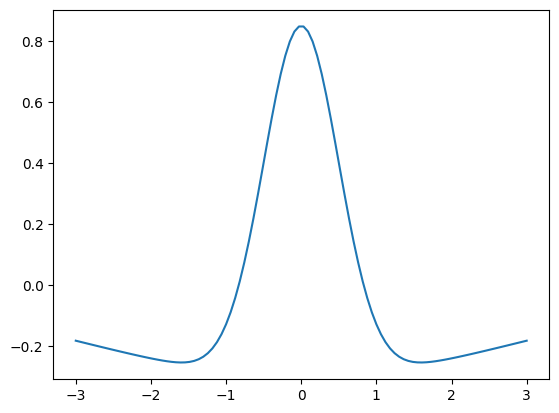

In [ ]:
import matplotlib.pyplot as plt

x = jnp.linspace(-3, 3, 100)
h = 0.15
s = 6
sigma = 0.5
theta = 0
gaussian1 = lambda x, mu, std: jnp.exp(-0.5*((x-mu)/std)**2)

df1 = (1+h)*gaussian1(x, theta, sigma) - 2*h*gaussian1(x, theta, s*sigma)

plt.plot(x, df1)

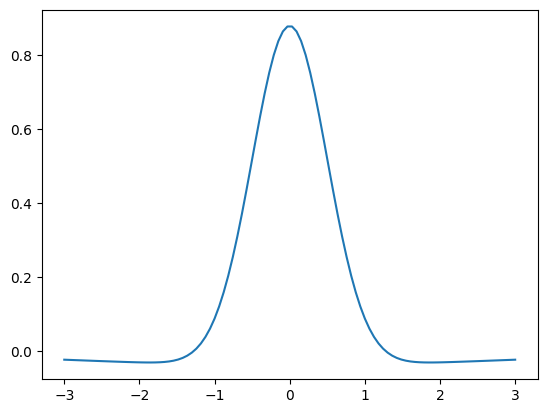

In [ ]:
import matplotlib.pyplot as plt

x = jnp.linspace(-3, 3, 100)
h = 0.15
s = 6
sigma = 0.5
theta = 0
gaussian2 = lambda x, mu, std: 1/((2*jnp.pi)**(0.5) * std) * jnp.exp(-0.5*((x-mu)/std)**2)

df2 = (1+h)*gaussian2(x, theta, sigma) - h*gaussian2(x, sigma, s*sigma) - h*gaussian2(x, -sigma, s*sigma)

plt.plot(x, df2)

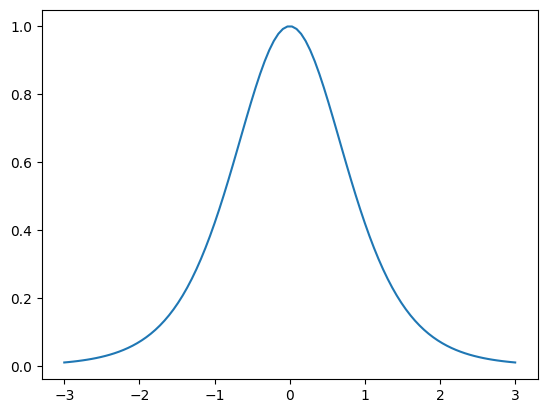

In [ ]:
import matplotlib.pyplot as plt

x = jnp.linspace(-3, 3, 100)
h = 0.15
s = 6
sigma = 0.5
theta = 0
gaussian2 = lambda x, mu, std: 1/((2*jnp.pi)**(0.5) * std) * jnp.exp(-0.5*((x-mu)/std)**2)

df3 = (4 / (jnp.exp(-x) + jnp.exp(x))**2).astype(jnp.float32)

plt.plot(x, df3)

In [ ]:
df1

Array([-0.1819592 , -0.18563461, -0.18930697, -0.19297318, -0.19663006,
       -0.2002744 , -0.20390277, -0.20751178, -0.21109776, -0.21465683,
       -0.21818455, -0.22167593, -0.22512493, -0.22852369, -0.23186195,
       -0.23512554, -0.23829465, -0.2413413 , -0.24422574, -0.24689226,
       -0.24926306, -0.25123146, -0.2526533 , -0.25333732, -0.25303504,
       -0.2514304 , -0.24813028, -0.24265866, -0.23445383, -0.22287321,
       -0.20720647, -0.18669921, -0.16058876, -0.12815219, -0.08876692,
       -0.04197864,  0.01242331,  0.07433322,  0.14326552,  0.218303  ,
        0.29807678,  0.38077053,  0.46416557,  0.545722  ,  0.6226941 ,
        0.69227916,  0.7517796 ,  0.79877555,  0.8312857 ,  0.84790516,
        0.8479053 ,  0.8312856 ,  0.79877543,  0.7517794 ,  0.69227874,
        0.62269396,  0.5457219 ,  0.46416557,  0.38077053,  0.29807666,
        0.21830288,  0.14326513,  0.07433337,  0.01242319, -0.04197876,
       -0.08876692, -0.12815228, -0.16058876, -0.18669921, -0.20

In [ ]:
df2

Array([-0.02419551, -0.02467065, -0.02514511, -0.02561849, -0.02609037,
       -0.0265603 , -0.02702779, -0.02749225, -0.02795301, -0.02840917,
       -0.02885954, -0.02930235, -0.02973505, -0.0301537 , -0.03055238,
       -0.03092209, -0.03124932, -0.03151398, -0.0316867 , -0.03172521,
       -0.03156971, -0.03113728, -0.03031506, -0.02895266, -0.02685388,
       -0.02376859, -0.01938523, -0.01332592, -0.00514445,  0.00567004,
        0.01968245,  0.03749296,  0.05970845,  0.08690403,  0.11957496,
        0.15808219,  0.20259243,  0.25302   ,  0.30897623,  0.3697282 ,
        0.43418255,  0.5008891 ,  0.5680768 ,  0.63371813,  0.6956218 ,
        0.751551  ,  0.79935265,  0.83709574,  0.8631992 ,  0.8765417 ,
        0.87654173,  0.86319906,  0.8370956 ,  0.7993525 ,  0.7515507 ,
        0.6956217 ,  0.6337181 ,  0.5680768 ,  0.50088906,  0.4341824 ,
        0.36972812,  0.30897593,  0.25302008,  0.2025923 ,  0.15808208,
        0.11957496,  0.08690397,  0.05970845,  0.03749296,  0.01

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

P0 = lambda x: np.ones_like(x)
P1 = lambda x: x
P2 = lambda x: (1/2) * (3 * x**2 - 1)
P3 = lambda x: (1/2) * (5 * x**3 - 3*x)
P4 = lambda x: (1/8) * (35 * x**4 - 30*x**2 + 3)
P5 = lambda x: (1/8) * (63 * x**5 - 70*x**3 + 15*x)
P6 = lambda x: (1/16) * (231 * x**6 - 315*x**4 + 105*x**2-5)

factor = lambda n: (2*n+1) / 2

x = np.linspace(-6, 6, 100)
x0 = 0.5
y = factor(0)*P0(x0)*P0(x) * factor(1)*P1(x0)*P1(x) * factor(2)*P2(x0)*P2(x) * factor(3)*P3(x0)*P3(x) * factor(4)*P4(x0)*P4(x) * factor(5)*P5(x0)*P5(x) * factor(6)*P6(x0)*P6(x)

In [ ]:
plt.plot(x, y)

In [ ]:
plt.plot(x, P6(x))

In [ ]:
def sin(m, x):
    # return 2**(0.5) * np.sin(2*np.pi * m * x)
    return np.sin(2*np.pi * m * x)

def cos(m, x):
    # return 2**(0.5) * np.cos(2*np.pi * m * x)
    return np.cos(2*np.pi * m * x)

def basis(n, x):
    if np.abs(n) % 2 == 0:
        return sin(n/2, x)
    else:
        return cos(int(n/2), x)


x = np.linspace(-5, 5, 100)
x0 = 2.1
y = np.sum(np.array([basis(n, x0) * basis(n, x) for n in range(-64, 64, 1)]), axis=0)

In [ ]:
plt.plot(x, y)

In [ ]:
y = [0, 0, 1, 0, 0]
np.fft.fft(y*2)